In [1]:
from climpyrical.gridding import find_nearest_index, find_element_wise_nearest_pos
from climpyrical.mask import gen_raster_mask_from_vector
import climpyrical.spytialProcess as sp


from rpy2.robjects.packages import importr
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from scipy.interpolate import NearestNDInterpolator
from tqdm import tqdm
import dask.array as da
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import matplotlib



importr("fields")

/home/nannau/tri/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


rpy2.robjects.packages.Package as a <module 'fields'>

In [2]:
dsold = xr.open_dataset('/home/nannau/nrc_data/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc')
dsold_max = dsold.rlat.values.max()

ds = xr.open_dataset('./data/processed/pre_processed.nc')
mask = xr.open_dataset('./data/processed/canada_mask_rp.nc')['mask'].values

In [3]:
ds

<xarray.Dataset>
Dimensions:  (rlat: 1510, rlon: 1550)
Coordinates:
  * rlon     (rlon) float64 -34.28 -34.23 -34.19 -34.14 ... 34.19 34.23 34.28
  * rlat     (rlat) float64 -29.0 -28.95 -28.91 -28.86 ... 37.77 37.82 37.86
Data variables:
    snw      (rlat, rlon) float64 ...

In [4]:
# station_dv = 'RL50 (kPa)'
# dv = 'Rain-RL50'

# station_dv = 'HDD (degC-day)'
# dv = 'heating_degree_days_per_time_period'

station_dv = 'SL50 (kPa)'
dv = 'snw'

df = pd.read_csv('./data/processed/processed_station.csv')
df_nrc = pd.read_csv('./data/processed/nrc_locations.csv')

# df = df[df[station_dv] != 0.0]

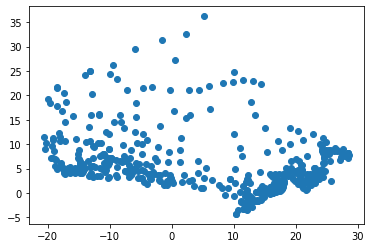

In [5]:
import matplotlib.pyplot as plt
plt.scatter(df.rlon, df.rlat)
plt.show()

In [6]:
df_north = df[df.rlat > dsold_max].copy()
df_no_zero = df[df[station_dv] != 0.0]
df_south = df_no_zero[df_no_zero.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

df

,Unnamed: 0,ilocy,ilocx,SL50 (kPa),rlat,rlon,lat,lon,station_name,ratio,model_vals,best_tol
0,0,558,1009,1.0,-4.286849,10.373390,42.27560,-82.95560,WINDSOR A,1.184540,0.602379,0.713542
1,1,559,1009,1.2,-4.227125,10.379271,42.33330,-82.93330,WINDSOR RIVERSIDE,1.413389,0.605814,0.713542
2,2,576,1017,1.5,-3.494586,10.713492,42.99220,-82.30470,SARNIA AIRPORT,1.448106,0.739112,0.713542
3,3,577,1048,1.4,-3.434479,12.106219,42.77439,-80.42906,HAGERSVILLE 2 composite,1.192637,0.837605,0.713542
4,4,579,1046,1.5,-3.362845,11.999925,42.86670,-80.55000,DELHI CDA,1.342166,0.797452,0.713542
...,...,...,...,...,...,...,...,...,...,...,...,...
513,513,1269,788,1.5,27.224763,0.601810,74.71690,-94.96940,RESOLUTE CARS,0.688837,1.553797,0.713542
514,514,1322,640,1.2,29.596811,-5.969242,76.23330,-119.33300,MOULD BAY A,0.650864,1.315559,0.713542
515,515,1362,741,1.6,31.345756,-1.484925,78.78330,-103.53300,ISACHSEN,0.686823,1.662243,0.713542
516,516,1391,826,0.9,32.645419,2.272431,79.98330,-85.93330,EUREKA A,0.329829,1.947032,0.713542


# Krig the station only values in the north

In [7]:
X_n_d =  np.stack([np.deg2rad(df.lat), np.deg2rad(df.lon)]).T

nbrs = NearestNeighbors(n_neighbors=20, metric='haversine').fit(X_n_d)
dist, ind = nbrs.kneighbors(X_n_d)
imax = df.rlat.idxmax(axis=0, skipna=True)
temp_df = df.iloc[ind[imax]]

xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

latlon = np.stack([temp_df.rlon, temp_df.rlat])
stats = temp_df[station_dv]

lw, u = find_nearest_index(ds.rlat.values, ymin), find_nearest_index(ds.rlat.values, ymax)
l, r = find_nearest_index(ds.rlon.values, xmin), find_nearest_index(ds.rlon.values, xmax)
ylim = u-lw
xlim = r-l    

z, x, y = sp.fit(latlon, stats, xlim, ylim, extrap=True)

final = ds[dv].values.copy()
final[:, :] = np.nan
final[lw:u, l:r] = z.T

nanmask = ~np.isnan(final)

station_final_north = final.copy()

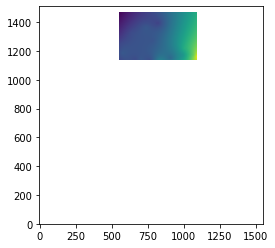

In [8]:
plt.imshow(station_final_north, origin = 'lower')

<AxesSubplot:>

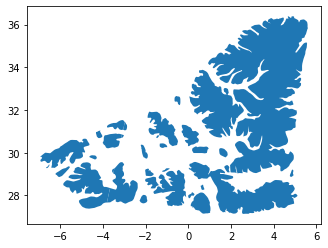

In [9]:
canada = gpd.read_file('./data/processed/canada_final.shp').geometry
def to_polygons(geometries):
    for geometry in geometries:
        if isinstance(geometry, Polygon):
            yield geometry
        else:
            yield from geometry

canada_polygons = MultiPolygon(to_polygons(canada))
polygon_above_north_idx = np.array([p.centroid.y + 1 >= dsold_max for p in canada]) 
M2 = gpd.GeoSeries(MultiPolygon([P for P in canada_polygons if P.centroid.y + 1 >= dsold_max]))
M2.plot()

100%|██████████| 59147/59147 [00:14<00:00, 4105.52it/s]


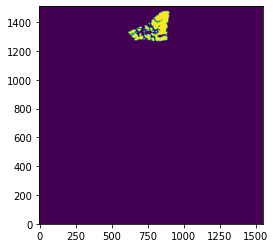

In [10]:
northern_mask = np.zeros(ds[dv].shape) == 1.0
north_ext = 210
northern_mask[-(north_ext+50):, :] = gen_raster_mask_from_vector(
    ds.rlon.values, 
    ds.rlat.values[-(north_ext+50):], 
    M2
)

station_final_north[~northern_mask] = np.nan
plt.imshow(northern_mask, origin='lower')

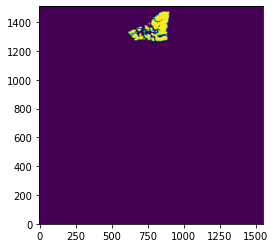

In [11]:
plt.imshow(~np.isnan(station_final_north), origin='lower')

## Find areas in north that are not covered by station only reconstruction

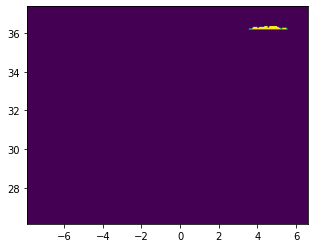

In [12]:
north_nan = ~np.isnan(station_final_north)
missed_station_only = (northern_mask^north_nan)

extent = [ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(), ds.rlat.values.max()]

plt.imshow(missed_station_only, origin='lower', extent=extent)
plt.gca().set_ylim(M2.bounds.miny.min()-1, M2.bounds.maxy.max()+1)
plt.gca().set_xlim(M2.bounds.minx.min()-1, M2.bounds.maxx.max()+1)
plt.show()

# station_final_north[~northern_mask] = np.nan

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
f = NearestNDInterpolator(np.stack([rlon[north_nan], rlat[north_nan]]).T, station_final_north[north_nan])

station_final_north_filled = station_final_north.copy()
station_final_north_filled[missed_station_only] = f(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


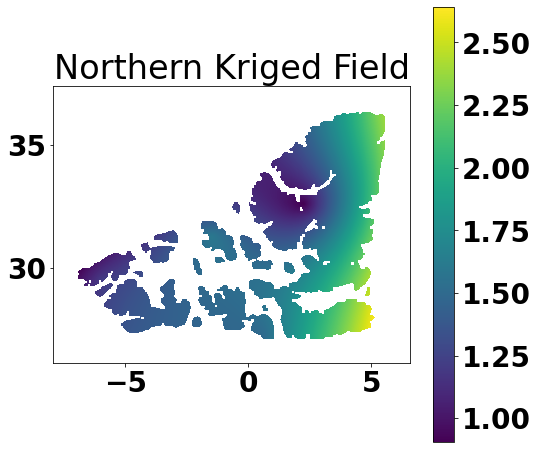

In [13]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 28}

matplotlib.rc('font', **font)

extent = [ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(), ds.rlat.values.max()]
fig, ax = plt.subplots(figsize=(8, 8))
img = ax.imshow(station_final_north_filled, origin='lower', extent = extent)
ax.set_ylim(M2.bounds.miny.min()-1, M2.bounds.maxy.max()+1)
ax.set_xlim(M2.bounds.minx.min()-1, M2.bounds.maxx.max()+1)
plt.colorbar(img)
plt.title("Northern Kriged Field")
plt.savefig("northern_krig")

In [14]:
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df.rlon.values, 
            df.rlat.values
)

df['ilocy'] = iy 
df['ilocx'] = ix
df
np.any(df.ratio < 0)

False

In [15]:
# choose starting value
model_vals = ds[dv].values[df.ilocy.values, df.ilocx.values]
station_vals = df[station_dv]
best_tol = df.best_tol.mean()    

print(best_tol)

# apply correction
model_vals_corrected = model_vals/best_tol
mean_corrected = ds[dv].values/best_tol

mean_corrected

0.7135418413725744


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [16]:
df

,Unnamed: 0,ilocy,ilocx,SL50 (kPa),rlat,rlon,lat,lon,station_name,ratio,model_vals,best_tol
0,0,558,1009,1.0,-4.286849,10.373390,42.27560,-82.95560,WINDSOR A,1.184540,0.602379,0.713542
1,1,559,1009,1.2,-4.227125,10.379271,42.33330,-82.93330,WINDSOR RIVERSIDE,1.413389,0.605814,0.713542
2,2,576,1017,1.5,-3.494586,10.713492,42.99220,-82.30470,SARNIA AIRPORT,1.448106,0.739112,0.713542
3,3,577,1048,1.4,-3.434479,12.106219,42.77439,-80.42906,HAGERSVILLE 2 composite,1.192637,0.837605,0.713542
4,4,579,1046,1.5,-3.362845,11.999925,42.86670,-80.55000,DELHI CDA,1.342166,0.797452,0.713542
...,...,...,...,...,...,...,...,...,...,...,...,...
513,513,1269,788,1.5,27.224763,0.601810,74.71690,-94.96940,RESOLUTE CARS,0.688837,1.553797,0.713542
514,514,1322,640,1.2,29.596811,-5.969242,76.23330,-119.33300,MOULD BAY A,0.650864,1.315559,0.713542
515,515,1362,741,1.6,31.345756,-1.484925,78.78330,-103.53300,ISACHSEN,0.686823,1.662243,0.713542
516,516,1391,826,0.9,32.645419,2.272431,79.98330,-85.93330,EUREKA A,0.329829,1.947032,0.713542


In [17]:
Zl = []

X_distances = np.stack([np.deg2rad(df.lat.values), np.deg2rad(df.lon.values)])
dx = ((np.amax(ds.rlon.values)-np.amin(ds.rlon.values))/ds.rlon.size)
dy = ((np.amax(ds.rlat.values)-np.amin(ds.rlat.values))/ds.rlat.size)
dA = dx*dy

def krig_at_field(ds, temp_df):
        
    xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
    ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

    latlon = np.stack([temp_df.rlon, temp_df.rlat])
    stats = temp_df.ratio

    lw, u = find_nearest_index(ds.rlat.values, ymin), find_nearest_index(ds.rlat.values, ymax)
    l, r = find_nearest_index(ds.rlon.values, xmin), find_nearest_index(ds.rlon.values, xmax)

    ylim = u-lw
    xlim = r-l

    latlon = np.stack([temp_df.rlon, temp_df.rlat])
    stats = temp_df.ratio

    z, x, y = sp.fit(latlon, stats, xlim, ylim, extrap=False)

    final = np.ones(ds[dv].values.shape, dtype=np.float16)
    final[:] = np.nan
    final[lw:u, l:r] = z.T
    
    return final

with tqdm(total=len(south_index), position=0, leave=True) as pbar:
    for i in south_index:
        pbar.update()
        nn = 30

        nbrs = NearestNeighbors(n_neighbors=nn, metric='haversine').fit(X_distances.T)
        dist, ind = nbrs.kneighbors(X_distances.T)
        temp_df = df.iloc[ind[i]]

        latlon = np.stack([temp_df.rlon, temp_df.rlat])
        stats = temp_df.ratio
        hull = ConvexHull(points=latlon.T)

        while hull.area < dA*(3*10)**2:
            nn+=1
            nbrs = NearestNeighbors(n_neighbors=nn, metric='haversine').fit(X_distances.T)
            dist, ind = nbrs.kneighbors(X_distances.T)

            temp_df = df.iloc[ind[i]]
            hull = ConvexHull(points=latlon.T)

        try:
            final = krig_at_field(ds, temp_df)
            final_da = da.from_array(final, chunks=(250, 250))
            Zl.append(final_da)
        except:
            continue

 61%|██████    | 312/514 [03:57<03:21,  1.00it/s]R[write to console]: Error in if (any(d < 0)) stop("distance argument must be nonnegative") : 
  missing value where TRUE/FALSE needed

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/local/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/local/lib/R/site-library’ contains no packages

R[write to console]: 3: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/local/lib/R/site-library’ contains no packages

R[write to console]: Timing stopped

In [18]:
cxmin, cxmax, cymin, cymax = canada.bounds.minx.min(), canada.bounds.maxx.max(), canada.bounds.miny.min(), canada.bounds.maxy.max()

In [19]:
final = np.zeros(ds[dv].shape)
final = da.stack(Zl, axis=0)
final = da.nanmean(final, axis = 0)
ratio = final.compute()
ratio[~mask] = np.nan

/home/nannau/tri/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


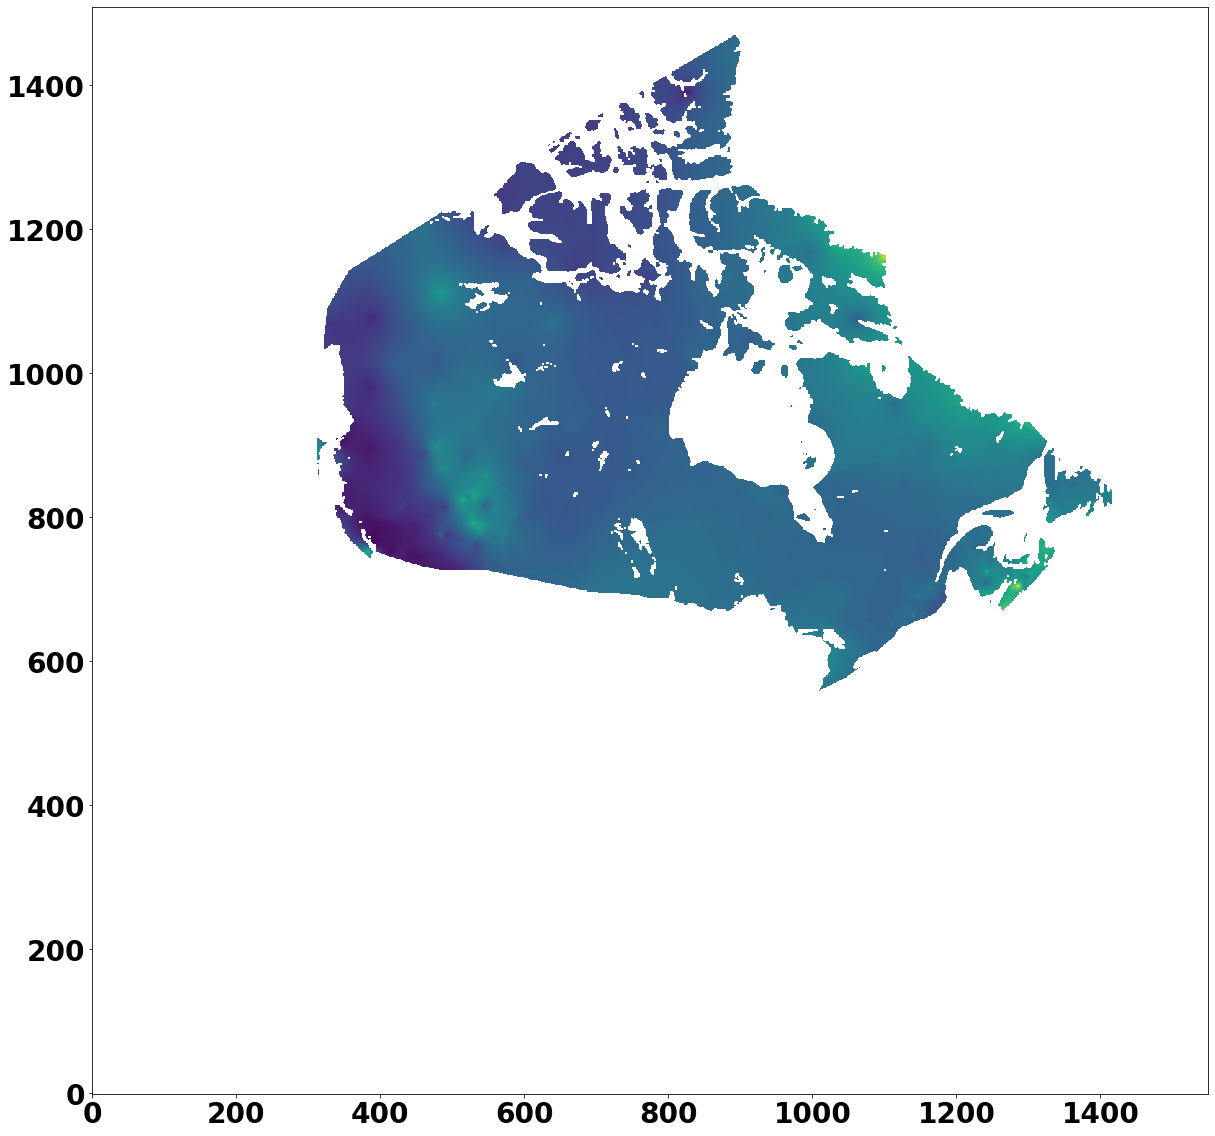

In [20]:
ratio = np.array(ratio, dtype=np.float)
plt.figure(figsize=(20, 20))
plt.imshow(ratio, origin='lower')


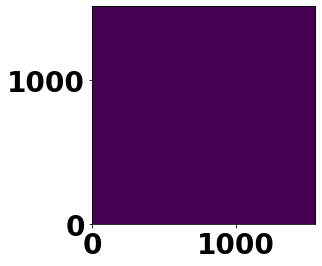

In [21]:
nanmask = ~np.isnan(ratio)
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
ratio_final = ratio.copy()

f = NearestNDInterpolator(np.stack([rlon[nanmask], rlat[nanmask]]).T, ratio[nanmask])

ratio_final[nanmask^mask] = f(np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T)
ratio_final = ratio_final*mean_corrected

plt.imshow(ratio_final < 0, origin='lower')

/home/nannau/tri/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nannau/tri/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nannau/tri/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


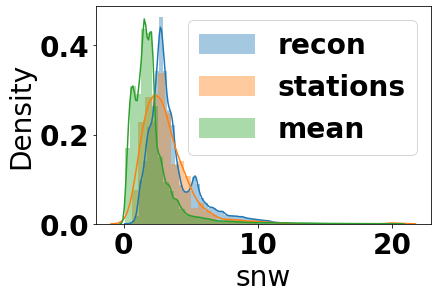

In [22]:
import seaborn as sns
sns.distplot(ratio_final, label='recon')
sns.distplot(df[station_dv], label='stations')
sns.distplot(ds[dv], label='mean')
plt.legend()

In [23]:
from shapely.geometry import MultiPolygon
pts=[]
for poly in canada:
    if isinstance(poly, MultiPolygon):
        for p in poly:
            pts.extend(p.exterior.coords)
            pts.append([None, None])
    else:
        pts.extend(poly.exterior.coords)
        pts.append([None, None])

X, Y = zip(*pts)

In [24]:
np.sum(ratio < 0)

0

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


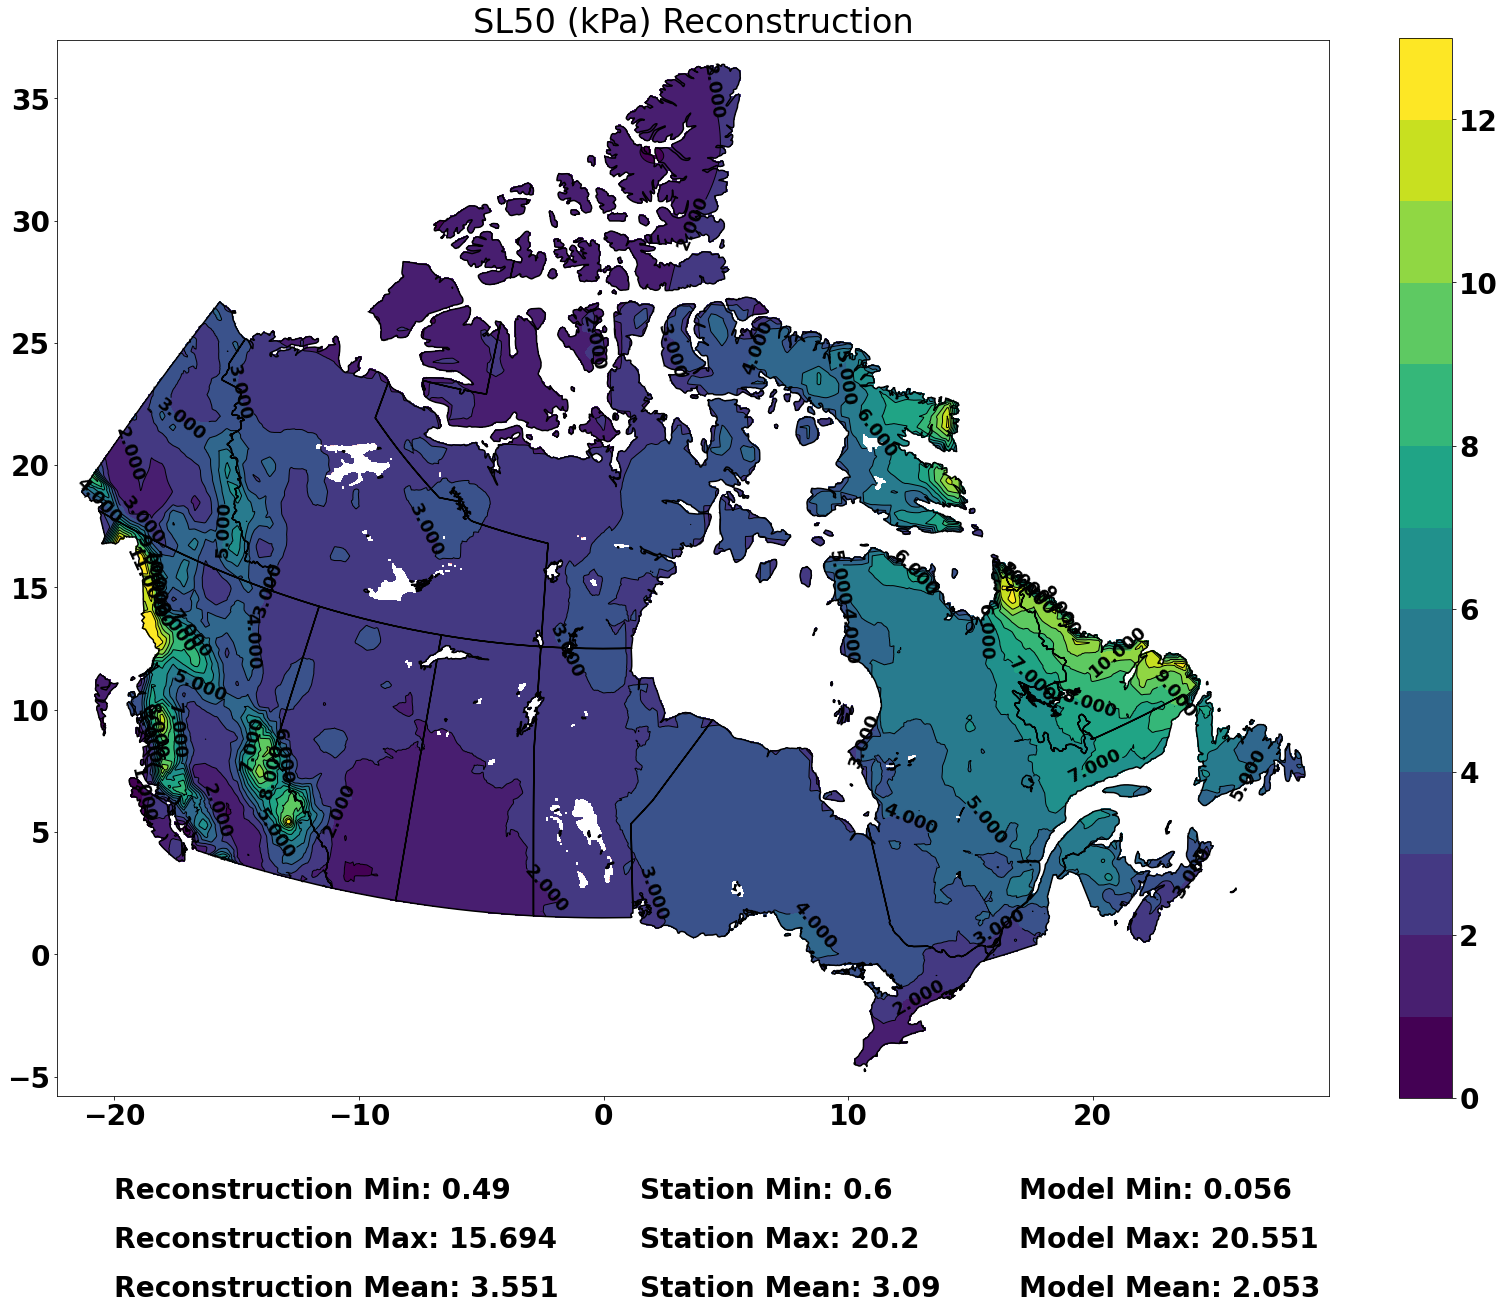

In [33]:
ratio_final[northern_mask] = np.array(station_final_north_filled)[northern_mask]
ratio_final[~mask] = np.nan
fig, ax = plt.subplots(figsize=(25, 25))

# vmax = np.nanmax(df[station_dv].values)
# vmin = np.nanmin(df[station_dv].values)
vmin = 0
vmax = 13


N = 13
cont = np.arange(vmin, vmax, 1)
print(cont)

# vmax = np.nanmax(ratio_final)-3


ax.text(-20, -10, 'Reconstruction Min: {}'.format(np.round(np.nanmin(ratio_final), 3)))
ax.text(-20, -12, 'Reconstruction Max: {}'.format(np.round(np.nanmax(ratio_final), 3)))
# ax.text(-13, -12, 'Reconstruction Max: {}'.format(np.nanmax(ratio_final)))
ax.text(-20, -14, 'Reconstruction Mean: {}'.format(np.round(np.nanmean(ratio_final), 3)))


ax.text(1.5, -10, 'Station Min: {}'.format(np.round(np.min(df[station_dv]), 3)))
ax.text(1.5, -12, 'Station Max: {}'.format(np.max(df[station_dv])))
ax.text(1.5, -14, 'Station Mean: {}'.format(np.round(np.nanmean(df[station_dv]), 3)))

ax.text(17, -10, 'Model Min: {}'.format(np.round(np.nanmin(ds[dv]), 3)))
ax.text(17, -12, 'Model Max: {}'.format(np.round(np.nanmax(ds[dv]), 3)))
ax.text(17, -14, 'Model Mean: {}'.format(np.round(np.nanmean(ds[dv]), 3)))

col1 = ax.imshow(ratio_final, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, ratio_final, cont, colors='black', linewidths=1, zorder=4)
plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+' Reconstruction')
canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/plots/{dv}-full-reconstruction-patched.png')

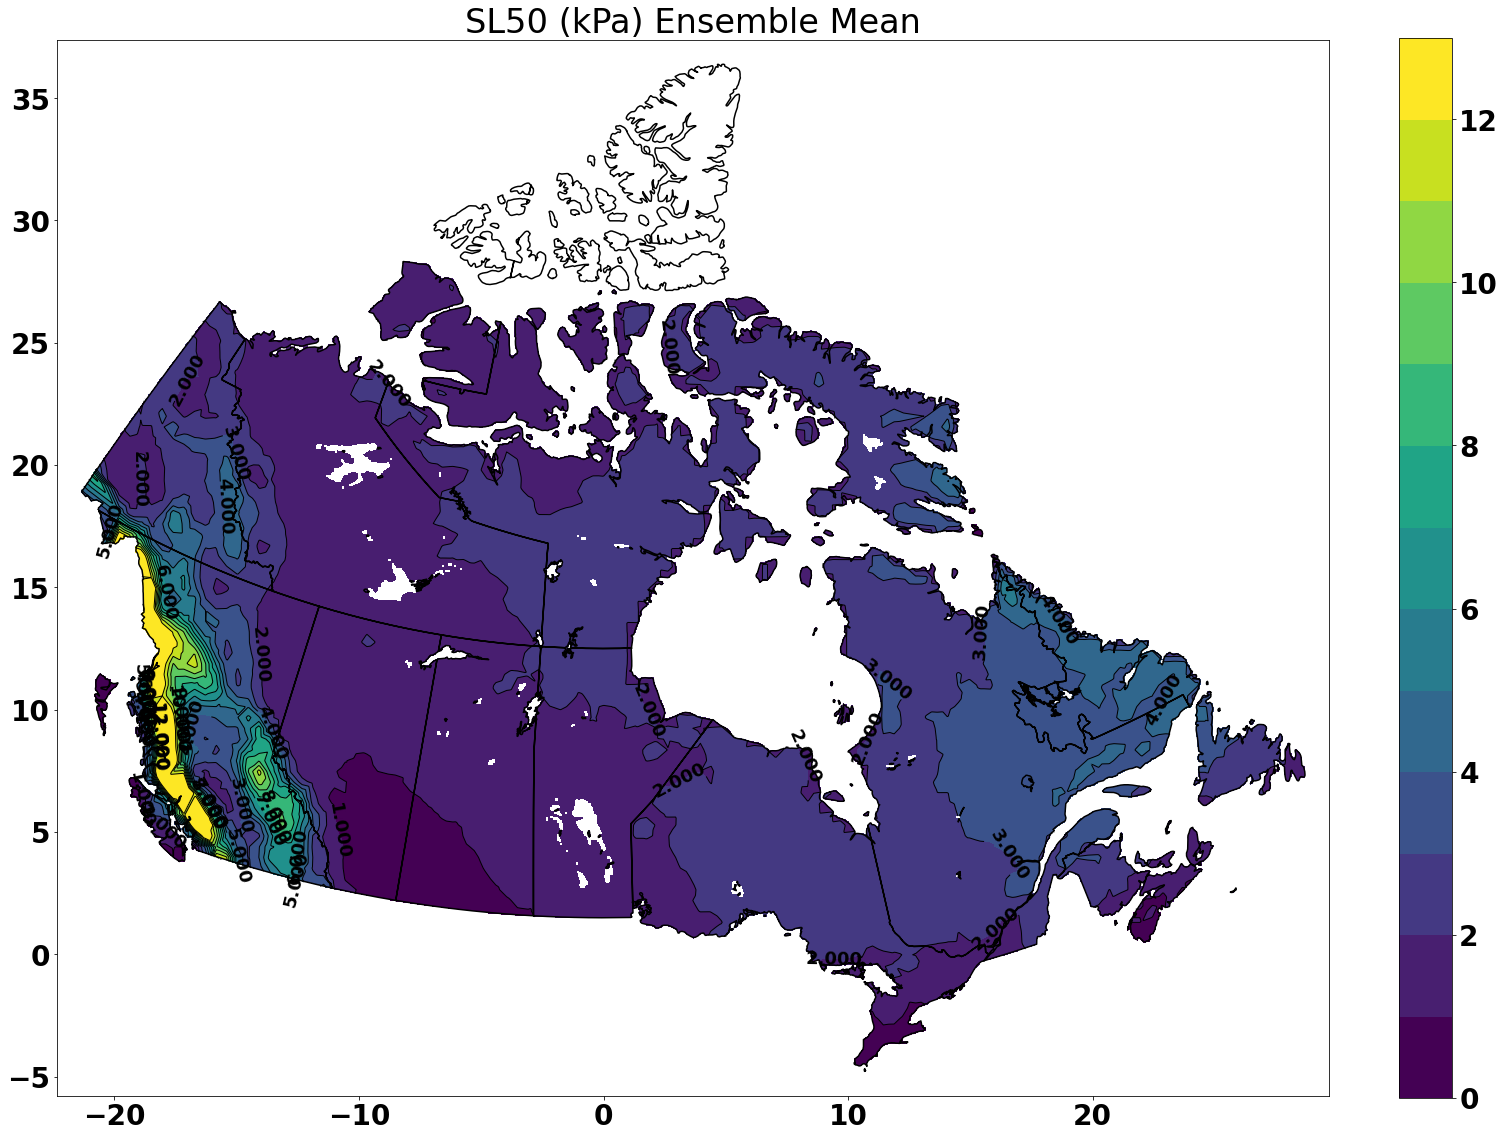

In [34]:
mean = ds[dv].values
mean[~mask] = np.nan
mean[northern_mask] = np.nan
fig, ax = plt.subplots(figsize=(25, 25))



col1 = ax.imshow(mean, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, mean, cont, colors='black', linewidths=1, zorder=4)
plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+' Ensemble Mean')
# canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/plots/{dv}-mean.png')

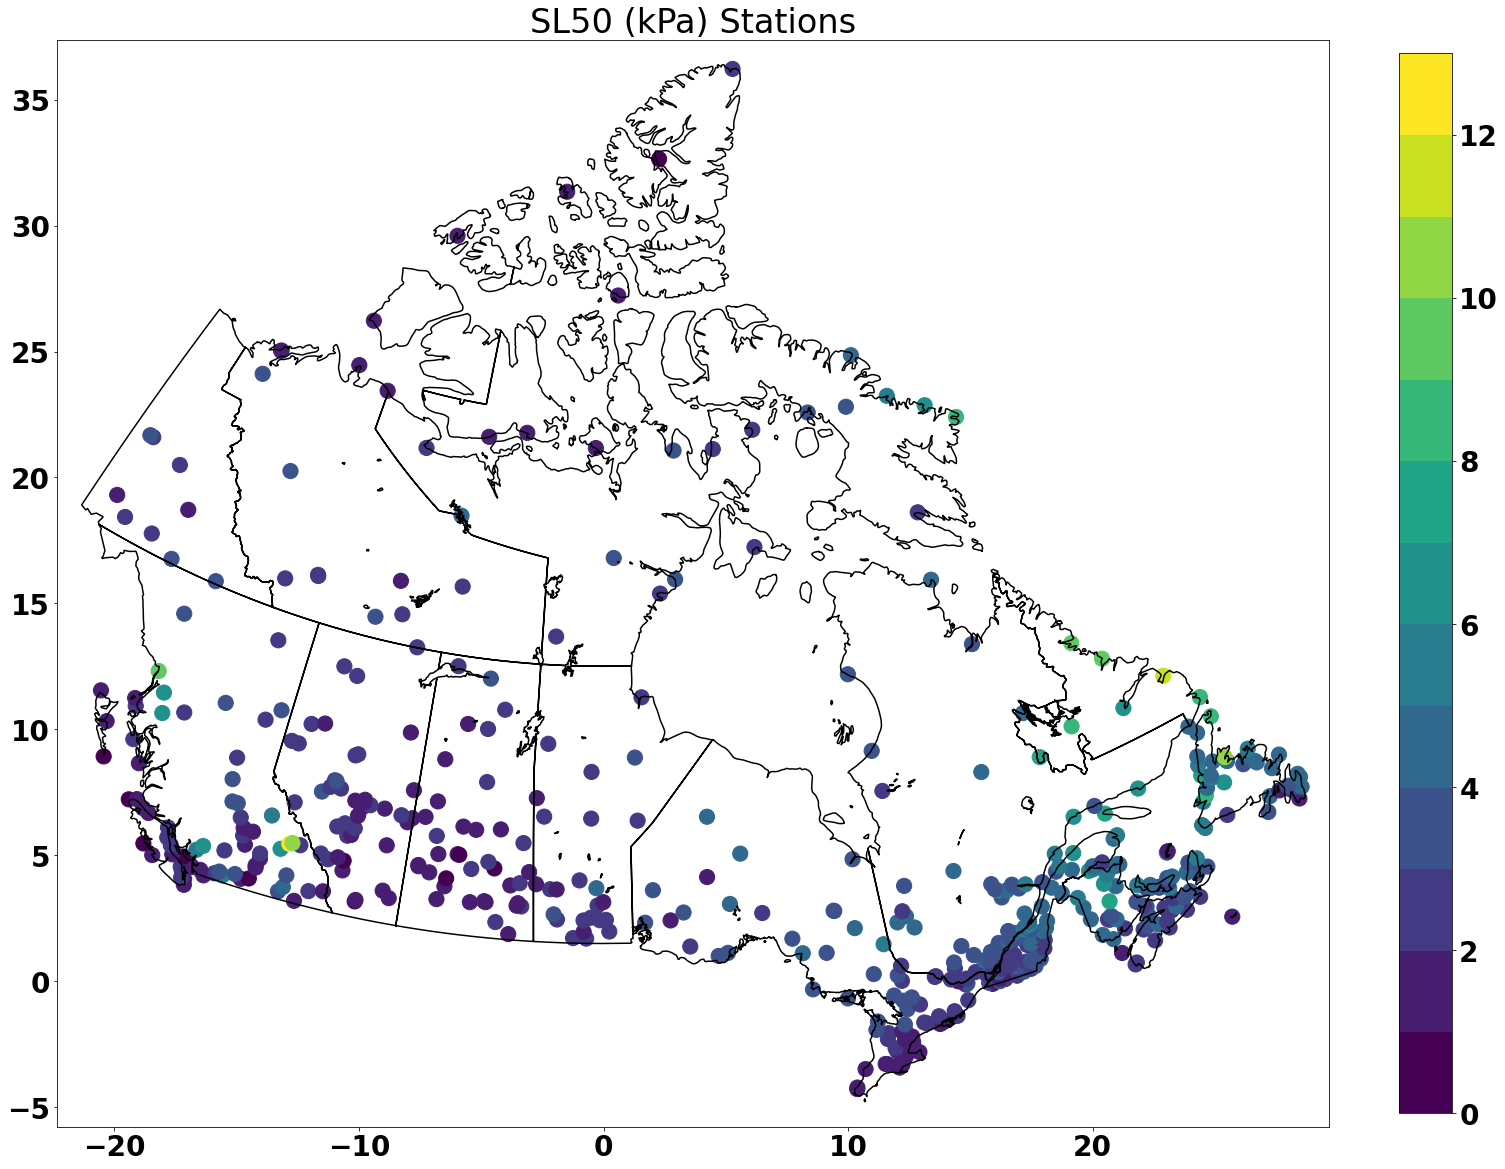

In [35]:
# ratio_final[northern_mask] = np.array(station_final_north_filled)[northern_mask]
# ratio_final[~mask] = np.nan
fig, ax = plt.subplots(figsize=(25, 20))

sc = ax.scatter(df.rlon, df.rlat, c = df[station_dv], s=230, vmin = vmin, vmax = vmax, cmap = plt.cm.get_cmap("viridis", N))
plt.colorbar(sc, ax = ax, fraction=0.038, pad=0.05)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

ax.set_title(station_dv+' Stations')
ax.plot(X, Y, color='black')

plt.savefig(f'./data/plots/{dv}-stations.png')

# Write to Table C-2


In [63]:
matched_df_nrc = pd.read_csv('./data/processed/nrc_locations.csv')

nrc_nan_df = matched_df_nrc[np.isnan(ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx])]

ratio_nan = ~np.isnan(ratio_final)
    
f = NearestNDInterpolator(np.stack([rlon[ratio_nan], rlat[ratio_nan]]).T, ratio_final[ratio_nan])

table_nan = f(
    np.stack(
        [rlon[nrc_nan_df.ilocy.values, nrc_nan_df.ilocx.values], 
         rlat[nrc_nan_df.ilocy.values, nrc_nan_df.ilocx.values]
        ]).T).T

# matched_df_nrc[''][np.isnan(ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx])] = table_nan
# matched_df_nrc

design_value = ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx]
dvnan = np.isnan(design_value)
design_value[dvnan] = table_nan

nrc_table = pd.DataFrame()
nrc_table = nrc_table.assign(
    Location=matched_df_nrc.Location, 
    lat=matched_df_nrc.lat, 
    lon=matched_df_nrc.lon,
    rlat=matched_df_nrc.rlat, 
    rlon=matched_df_nrc.rlon,
    SL50=design_value)

assert not df.isnull().values.any()

nrc_table.round(3).to_csv("./data/processed/table_c2_"+dv+".csv")